In [90]:
import numpy as np
import pandas as pd
import time
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Utilizando um dataset compreendendo apenas o primeiro trimestre de 2022 apenas para exemplificar o projeto, o projeto real utilizou dados de 3 anos

In [3]:
df = pd.read_csv(r'API\datasets\base_01012022_31032022.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31578 entries, 0 to 31577
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CD_PEDIDO       31578 non-null  int64  
 1   CD_CLIENTE      31578 non-null  int64  
 2   DS_CIDADE       31578 non-null  object 
 3   DS_UF           31578 non-null  object 
 4   CD_ITEM         31578 non-null  int64  
 5   CD_MATERIAL     31578 non-null  int64  
 6   DS_MATERIAL     31578 non-null  object 
 7   DT_CADASTRO     31578 non-null  object 
 8   DT_ATUALIZACAO  31578 non-null  object 
 9   DS_UNIDADE      31578 non-null  object 
 10  NR_QUANTIDADE   31578 non-null  float64
 11  VL_UNITARIO     31578 non-null  float64
 12  VL_TOTAL        31578 non-null  float64
 13  CD_VENDEDOR     31578 non-null  int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 3.4+ MB


### Esse dataset têm mais de 30 mil linhas pois os mesmos produtos estão em vários pedidos diferentes, quando criarmos a matriz de frequencia esse valor irá cair

In [5]:
df.shape

(31578, 14)

### Criando nossa matriz de frequencia de valores usando apenas as colunas CD_PEDIDO e CD_MATERIAL pois são elas que irão nos mostrar as relações entre os produtos

In [7]:
df = pd.crosstab(df.CD_PEDIDO, df.CD_MATERIAL)

### O novo tamanho de nosso dataframe é de cerca de 9 mil linhas, essa é a quantidade de produtos distintos vendidos nesse periodo

In [8]:
df.shape

(9658, 2155)

In [14]:
df.head()

CD_MATERIAL  3     5     6     7     8     9     10    11    12    13    14    \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  18    19    20    21    23    24    25    26    27    28    29    \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  30    31    33    34    36    38    73    75    76    77    82    \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  83    84    85    86    87    88    89    90    102   103   104   \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  105   108   114   115   131   136   137   138   141   142   143   \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  148   149   150   151   155   156   157   158   159   164   166   \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  168   169   172   175   178   180   182   183   184   185   188   \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  193   199  

### Para garantir que nosso algoritmo de itens frequentes vá funcionar da maneira correta iremos alterar todos os valores > 1 para o valor 1, já que a matriz deve estar como se fosse em valor Booleano, True e False

In [16]:
df[df>1] = 1

### Conforme documentação, nosso primeiro passo é criar um conjunto de itens frequentes, e para isso precisaremos do valor de min_support, esse valor é a quantidade de transações em que 2 ou mais itens estão presentes para que possamos considerar que sejam frequentes juntos, após a criação desse conjunto de dados iremos aplicar o algoritmo e aí sim criar as regras de associação

In [19]:
qt_transact = 10
calc_support = qt_transact / len(df.index)

### Decidimos utilizar o algoritmo APRIORI para esse projeto, utilizamos um min_support equivalente a 10 transações para esse dataset porém já tivemos um grande problema, custo computacional, o algoritmo APRIORI demorou alguns minutos para criar o conjunto de itens frequentes com esse suporte minimo calculado, com isso nos fazemos uma pergunta:
1- O algoritmo que tem um custo computacional alto ou o suporte minimo definido é muito baixo ?

In [24]:
frequent_itemsets_apriori = apriori(df, min_support=calc_support, use_colnames=True)
frequent_itemsets_apriori['length'] = frequent_itemsets_apriori['itemsets'].apply(lambda x: len(x))
frequent_itemsets_apriori[(frequent_itemsets_apriori['length'] >= 2)].sort_values('support', ascending = False).head()

,support,itemsets,length
832,0.018534,"(3944, 1236)",2
1236,0.013564,"(3932, 3933)",2
1179,0.013046,"(3744, 3743)",2
1091,0.009526,"(3694, 4046)",2
1254,0.008801,"(3958, 3959)",2


### Uma solução ao algoritmo apriori é o fpgrowth, alguns dizem ser uma versão melhorada do mesmo, apenas efetuando a troca já temos um ganho computacional significativo.
Enquanto o apriori faz iterações em todo o dataset, fazendo com que o custo computacional seja enorme, o fpgrowth trabalha com uma arvore de itens frequentes, fazendo com que seja criada uma arvore com os itens e depois feito o calculo de suas frequencias, com isso é muito mais rápido, conforme bloco abaixo.

In [23]:
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=calc_support, use_colnames=True)
frequent_itemsets_fpgrowth['length'] = frequent_itemsets_fpgrowth['itemsets'].apply(lambda x: len(x))
frequent_itemsets_fpgrowth[(frequent_itemsets_fpgrowth['length'] >= 2)].sort_values('support', ascending = False).head()

,support,itemsets,length
746,0.018534,"(3944, 1236)",2
1168,0.013564,"(3932, 3933)",2
1219,0.013046,"(3744, 3743)",2
1263,0.009526,"(3694, 4046)",2
1180,0.008801,"(3958, 3959)",2


### Após a constatação de que efetuar a troca do algoritmo é eficiente, podemos enfim criar o conjunto de regras, porém agora precisamos utilizar alguma métrica para isso e mais uma vez precisamos inferir o valor ideal, nesse primeiro momento iremos utilizar a metrica confidence com um valor de 50%


In [48]:
#Criando regra considerando 50% de confiança
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric = "confidence", min_threshold = 0.5)
rules_fpgrowth.sort_values(by=['confidence'], ascending = False)
rules_fpgrowth.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1067),(1049),0.007248,0.019155,0.004038,0.557143,29.085869,0.003899,2.214811
1,"(1067, 1957)",(1959),0.000518,0.012321,0.000518,1.000000,81.159664,0.000511,inf
2,"(1067, 1959)",(1957),0.000621,0.013357,0.000518,0.833333,62.390181,0.000509,5.919859
3,"(1058, 1067)",(1049),0.001139,0.019155,0.000725,0.636364,33.221622,0.000703,2.697323
4,"(1067, 3)",(1049),0.000932,0.019155,0.000518,0.555556,29.003003,0.000500,2.206901


In [27]:
#Adicionando duas colunas para determinar o tamanho de antecedents e consequents
rules_fpgrowth["antecedents_len"] = rules_fpgrowth["antecedents"].apply(lambda x: len(x))
rules_fpgrowth["consequents_len"] = rules_fpgrowth["consequents"].apply(lambda x: len(x))

In [29]:
rules_fpgrowth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         1402 non-null   object 
 1   consequents         1402 non-null   object 
 2   antecedent support  1402 non-null   float64
 3   consequent support  1402 non-null   float64
 4   support             1402 non-null   float64
 5   confidence          1402 non-null   float64
 6   lift                1402 non-null   float64
 7   leverage            1402 non-null   float64
 8   conviction          1402 non-null   float64
 9   antecedents_len     1402 non-null   int64  
 10  consequents_len     1402 non-null   int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 120.6+ KB


### Utilizando o min_support equivalente a 10 vendas, e um nivel de confiança equivalente a 50% temos um conjunto de regras de 1402 dados, porém nosso proposito é criar um sistema de recomendação de venda 1 para 1, ou seja, o algoritmo recebe um item e recomenda um item, ao filtrarmos nosso conjunto de regras para dados que cumpram esses requisitos, ficamos apenas com 188 regras, valor esse bem pequeno, com isso nos questionamos.
Os valores de min_support, nivel de confiança e até mesmo a metrica utilizada são os melhores para esse caso ?

In [30]:
#filtrando apenas os resultados com 1 antecedents e 1 consequents
rules_fpgrowth[ (rules_fpgrowth['antecedents_len'] == 1) &
       (rules_fpgrowth['consequents_len'] == 1)     
     ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 1401
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         188 non-null    object 
 1   consequents         188 non-null    object 
 2   antecedent support  188 non-null    float64
 3   consequent support  188 non-null    float64
 4   support             188 non-null    float64
 5   confidence          188 non-null    float64
 6   lift                188 non-null    float64
 7   leverage            188 non-null    float64
 8   conviction          188 non-null    float64
 9   antecedents_len     188 non-null    int64  
 10  consequents_len     188 non-null    int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 17.6+ KB


### Mesmo com poucas regras podemos fazer algumas considerações e avaliar o resultado

In [35]:
#Procurando regra referente ao item 1958
item = {1958}
resultado = rules_fpgrowth[rules_fpgrowth['antecedents'] == item]
resultado

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len,consequents_len
187,(1958),(1955),0.010872,0.012943,0.007248,0.666667,51.509333,0.007107,2.961172,1,1
188,(1958),(1959),0.010872,0.012321,0.006005,0.552381,44.831052,0.005871,2.206516,1,1
189,(1958),(1957),0.010872,0.013357,0.005488,0.504762,37.790624,0.005342,1.992260,1,1


### Ao procurar o item antecedent 1958 temos 3 regras de associação, junto com suas metricas equivalentes, podemos verificar que o valor de maior confiança está me recomendando o item 1955 como consequent, nesse caso que temos mais de uma regra poderiamos aplicar um filtro, por exemplo:

In [36]:
if len(resultado) > 1:
    confidence = resultado['confidence'].max()
    resultado = resultado[(resultado['confidence'] == confidence)]
else:
    pass
resultado

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len,consequents_len
187,(1958),(1955),0.010872,0.012943,0.007248,0.666667,51.509333,0.007107,2.961172,1,1


### Juntando isso tudo em uma função

In [38]:
def pred_consequent(rules, item):

    if item == 0:
        raise Exception('O código do item deve ser inteiro maior ou igual a 1, ou uma lista seguindo as mesmas regras.')
    elif type(item) == list:
        for i in range(len(item)):
            if type(item[i]) != int or item[i] == 0:
                raise Exception('Os valores dentro da lista devem ser inteiros maiores ou igual a 1.')
            else:
                pass
        item = frozenset(item)
    elif type(item) != int:
        raise Exception('O código do item deve ser inteiro maior ou igual a 1, ou uma lista seguindo as mesmas regras.')
    else:
        item = {item}
    
    resultado = rules[rules['antecedents'] == item]
    if len(resultado) > 1:
        confidence = resultado['confidence'].max()
        resultado = resultado[(resultado['confidence'] == confidence)]
        return resultado
    else:
        return resultado

In [39]:
pred_consequent(rules_fpgrowth, 1958)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len,consequents_len
187,(1958),(1955),0.010872,0.012943,0.007248,0.666667,51.509333,0.007107,2.961172,1,1


# OK
### Sabemos que nosso algoritmo funciona e já consegue nos recomendar produtos, porém será que aqueles valores de min_support, métrica e support da metrica que utilizamos são bons o suficientes?

### Foi decidido então criar uma pequena função que faria alguns testes com valores de min_support e nivel de confiança e plotaria isso em um gráfico, assim ficaria mais fácil decidir esses valores

In [33]:
def compare_association_rules(data, algorythm, min_supports, parameter, min_threshold, plot):
    """Cria um gráfico comparativo entre os suportes minimos e niveis de metrica e retorna um dataframe com as quantidades.

    Args:
        data (dataframe): dataframe com variavel de venda e de item (CD_LANCAMENTO, CD_MATERIAL)
        algorythm (module mlxtend.frequent_patterns): Algoritmo utilizado ('apriori', 'fpgrowth')
        min_supports (list): Lista com os min_supports
        parameter (str): Parametro utilizado ('confidence, lift, leverage, conviction')
        min_threshold (list or int): Lista com os min_threshold, ou apenas um valor
        plot (int): Imprime Gráfico unitário ou gráfico de comparação (0 = nao imprime grafico, 1 = unitario, 2 - comparacao)
    Returns:
        _type_: _description_
    """

    data[data>1] = 1
    rules_levels = []
    coluna1 = []
    coluna2 = []
    coluna3 = []

    for s in range(len(min_supports)):
        rules_levels.append([])
        itemsets = algorythm(data, min_support=min_supports[s], use_colnames=True)
        for c in range(len(min_threshold)):
            rl = association_rules(itemsets, metric = parameter, min_threshold = min_threshold[c])
            rules_levels[s].append(len(rl.index))
            
    for s in range(len(min_supports)):
        for i in range(len(rules_levels[0])):
            coluna1.append(min_supports[s])
            
    for c in range(len(min_supports)):
        for i in range(len(min_threshold)):
            coluna2.append(min_threshold[i])
    
    for r in range(len(rules_levels)):
        for i in range(len(rules_levels[r])):
            coluna3.append(rules_levels[r][i])
    
    dicionario = {
    'min_support': coluna1,
    'confidence': coluna2,
    'qt_itemsets': coluna3
    }
    df_classe = pd.DataFrame(dicionario)
    
    if plot == 1:
        for r in range(len(rules_levels)):
            with plt.style.context('seaborn'):
                plt.xlabel(f'{parameter} level')
                plt.ylabel('quantidade de regras')
                plt.plot(min_threshold, rules_levels[r], 'k--')
                plt.plot(min_threshold, rules_levels[r], 'go')
                plt.title(f'min_support = {min_supports[r]}\nEquivalente a {len(data.index)*min_supports[r]} vendas.')
                plt.show()
    elif plot == 2:
        for r in range(len(rules_levels)):
            with plt.style.context('seaborn'):
                plt.plot(min_threshold, rules_levels[r], label = f'min_support = {min_supports[r]}')
        plt.xlabel(f'{parameter} level')
        plt.ylabel('quantidade de regras')
        plt.title('Comparação de todos os suportes adicionados.')
        plt.legend()
        plt.show()        
    elif plot == 0:
        pass
    else:
        print('O parametro plot não tem valor válido.')
    
    return df_classe

### Para criar nosso gráfico comparativo vamos definir 6 valores de suportes minimos, valores equivalentes a 5, 6, 7, 8, 9 e 10 transações, e iremos plotar uma curva com niveis de confiança de 0 a 100% com variancia de 10%

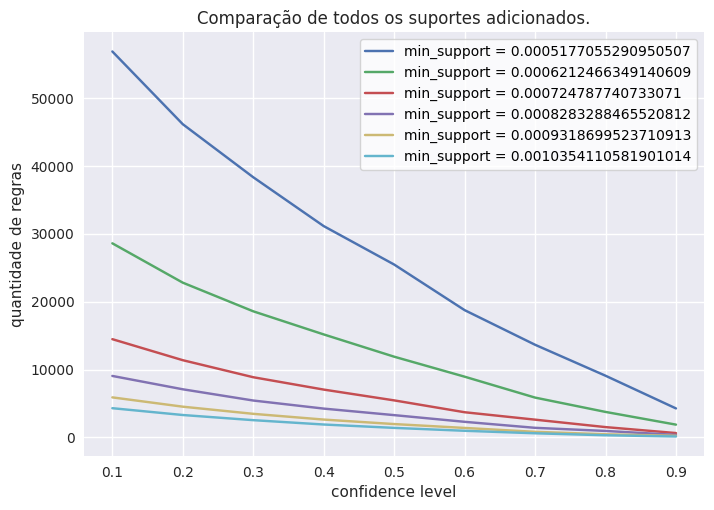

,min_support,confidence,qt_itemsets
0,0.000518,0.9,4269
1,0.000518,0.8,9088
2,0.000518,0.7,13651
3,0.000518,0.6,18752
4,0.000518,0.5,25471
5,0.000518,0.4,31136
6,0.000518,0.3,38333
7,0.000518,0.2,46148
8,0.000518,0.1,56866
9,0.000621,0.9,1880


In [45]:
min_supports = []
qt_transact = [5,6,7,8,9,10]
for valor in qt_transact:
    calc_support = valor / len(df.index)
    min_supports.append(calc_support)

min_threshold = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

compare_association_rules(df, fpgrowth, min_supports, 'confidence', min_threshold, 2)

### A partir do gráfico podemos verificar que o suporte equivalente a 10 transações gera poucas regras independente do valor de confiança, pra gente o melhor valor de suporte seria o equivalente a 5 transações, pois nos geram muitas regras acima de 50% de confiança, com isso iremos criar um novo conjunto de itens frequentes para que seja criado um novo conjunto de regras

In [46]:
qt_transact = 5
calc_support = qt_transact / len(df.index)
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=calc_support, use_colnames=True)
frequent_itemsets_fpgrowth['length'] = frequent_itemsets_fpgrowth['itemsets'].apply(lambda x: len(x))
frequent_itemsets_fpgrowth[(frequent_itemsets_fpgrowth['length'] >= 2)].sort_values('support', ascending = False).head()

,support,itemsets,length
1288,0.018534,"(3944, 1236)",2
3178,0.013564,"(3932, 3933)",2
3446,0.013046,"(3744, 3743)",2
3659,0.009526,"(3694, 4046)",2
3207,0.008801,"(3958, 3959)",2


### Com o conjunto de itens frequentes criados vamos criar novamente o conjunto de regras, dessa vez iremos utilizar a métrica lift, pois o calculo da métrica confidence não considera o suporte do item consequente e isso pode gerar menos regras, a métrica lift considera o nivel de confiança dividido pelo suporte do item consequente, com isso temos o seguinte:
Se lift <= 1: os itens são totalmente independentes
Se lift > 1: os itens possuem uma correlação

In [47]:
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric = "lift", min_threshold = 1.01)
rules_fpgrowth.sort_values(by=['lift'], ascending = False)
rules_fpgrowth.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1049),(1067),0.019155,0.007248,0.004038,0.210811,29.085869,0.003899,1.257939
1,(1067),(1049),0.007248,0.019155,0.004038,0.557143,29.085869,0.003899,2.214811
2,(1067),(6262),0.007248,0.021329,0.000621,0.085714,4.018585,0.000467,1.070421
3,(6262),(1067),0.021329,0.007248,0.000621,0.029126,4.018585,0.000467,1.022535
4,(1067),(1959),0.007248,0.012321,0.000621,0.085714,6.956543,0.000532,1.080273


In [49]:
rules_fpgrowth["antecedents_len"] = rules_fpgrowth["antecedents"].apply(lambda x: len(x))
rules_fpgrowth["consequents_len"] = rules_fpgrowth["consequents"].apply(lambda x: len(x))
rules_fpgrowth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25471 entries, 0 to 25470
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         25471 non-null  object 
 1   consequents         25471 non-null  object 
 2   antecedent support  25471 non-null  float64
 3   consequent support  25471 non-null  float64
 4   support             25471 non-null  float64
 5   confidence          25471 non-null  float64
 6   lift                25471 non-null  float64
 7   leverage            25471 non-null  float64
 8   conviction          25471 non-null  float64
 9   antecedents_len     25471 non-null  int64  
 10  consequents_len     25471 non-null  int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 2.1+ MB


In [50]:
rules_fpgrowth[ (rules_fpgrowth['antecedents_len'] == 1) &
       (rules_fpgrowth['consequents_len'] == 1)     
     ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449 entries, 0 to 25466
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         449 non-null    object 
 1   consequents         449 non-null    object 
 2   antecedent support  449 non-null    float64
 3   consequent support  449 non-null    float64
 4   support             449 non-null    float64
 5   confidence          449 non-null    float64
 6   lift                449 non-null    float64
 7   leverage            449 non-null    float64
 8   conviction          449 non-null    float64
 9   antecedents_len     449 non-null    int64  
 10  consequents_len     449 non-null    int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 42.1+ KB


In [51]:
pred_consequent(rules_fpgrowth, 1958)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len,consequents_len
9522,(1958),(1955),0.010872,0.012943,0.007248,0.666667,51.509333,0.007107,2.961172,1,1


### Podemos perceber que mesmo alterando os parametros para o item especifico 1958  a recomendação foi a mesma
Apenas para exemplificar iremos mostrar os gráficos independentes de cada suporte

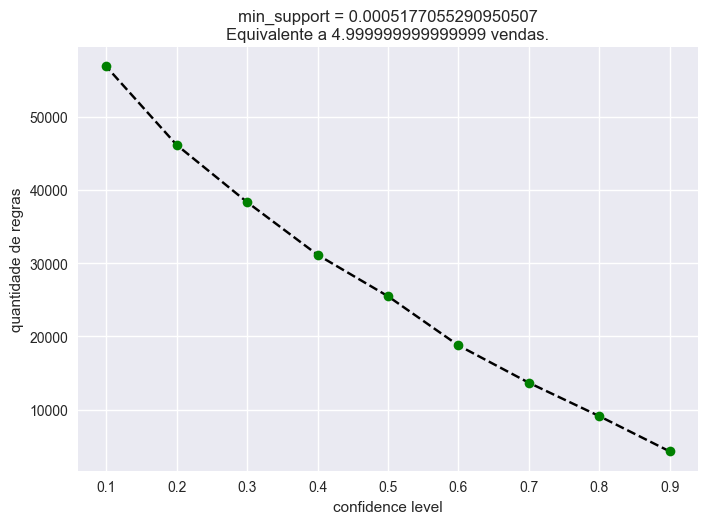

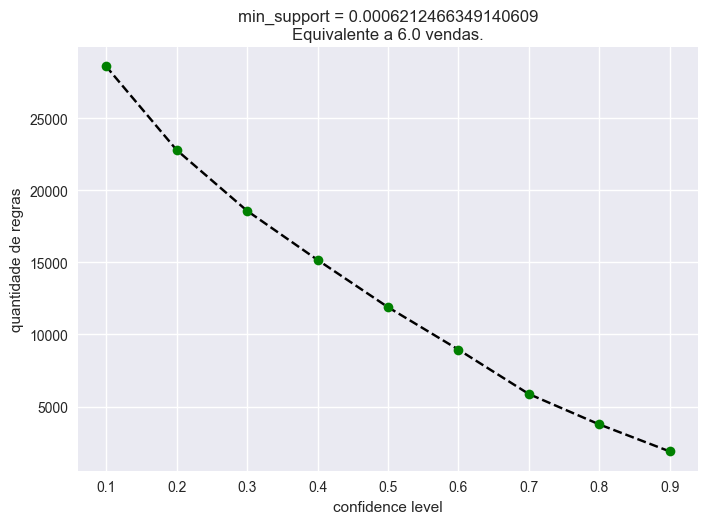

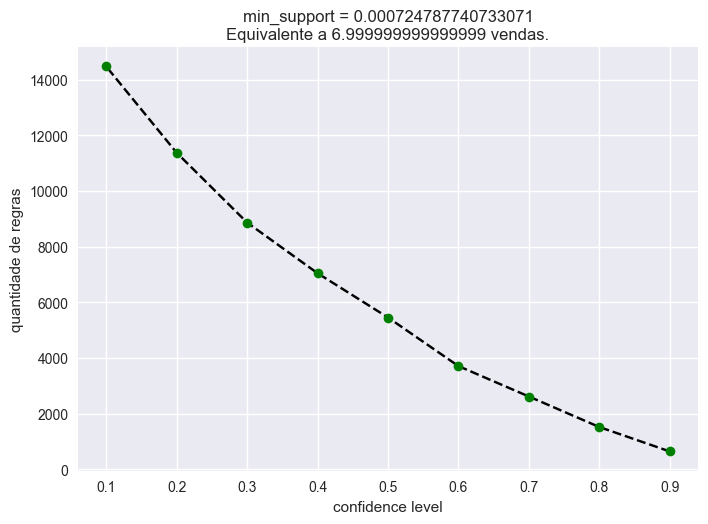

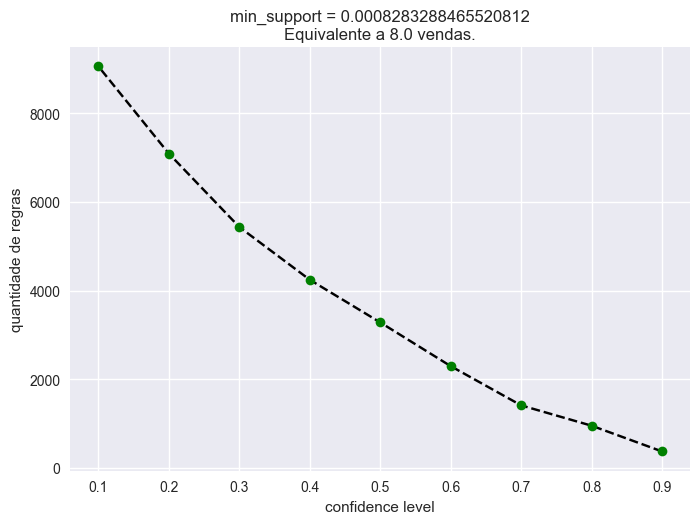

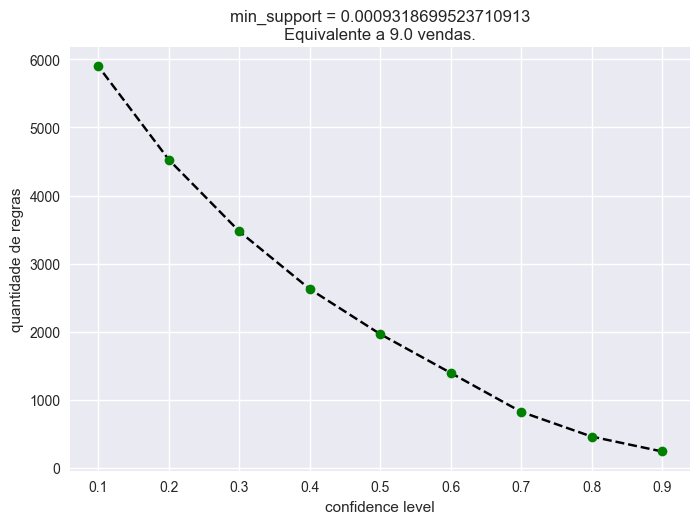

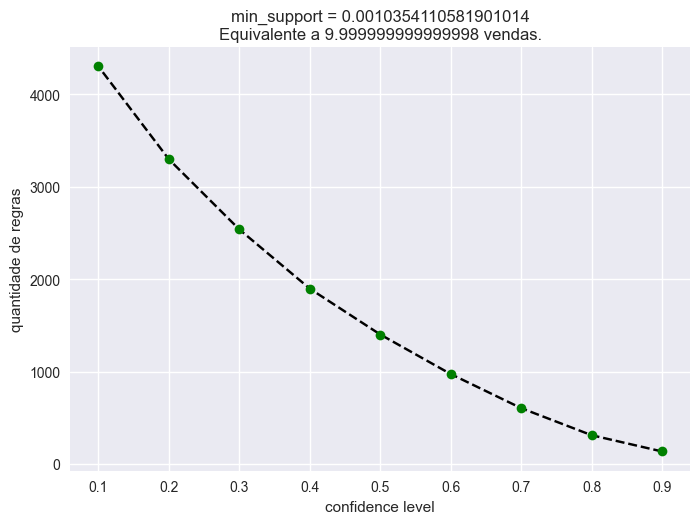

,min_support,confidence,qt_itemsets
0,0.000518,0.9,4269
1,0.000518,0.8,9088
2,0.000518,0.7,13651
3,0.000518,0.6,18752
4,0.000518,0.5,25471
5,0.000518,0.4,31136
6,0.000518,0.3,38333
7,0.000518,0.2,46148
8,0.000518,0.1,56866
9,0.000621,0.9,1880


In [52]:
compare_association_rules(df, fpgrowth, min_supports, 'confidence', min_threshold, 1)

# Fim dos testes
### Para esse caso especifico chegamos a essas conclusões de min_support, min_treshold e métrica utilizadas, o modelo final não se diferencia muito disso, foram apenas utilizados valores de suportes diferentes devido a quantidade e comportamento de dados diferentes, após a conclusão do modelo foram feitos alguns estudos afim de validar se o problema realmente é um problema, conforme blocos abaixo.

In [ ]:
#Select efetuado para extração dos dados a partir do banco de dados SQL SERVER
df_eda = """
    SELECT
    T1.CD_PEDIDO,
    T2.CD_CLIENTE,
    T4.DS_CIDADE,
    T4.DS_UF,
    T1.CD_ITEM, 
    T1.CD_MATERIAL, 
    T1.DS_MATERIAL, 
    (CASE WHEN T5.DT_CADASTRO IS NULL THEN T2.DT_CADASTRO ELSE T5.DT_CADASTRO END) AS DT_CADASTRO,
    T2.DT_ATUALIZACAO, 
    T1.DS_UNIDADE, 
    T1.NR_QUANTIDADE, 
    T1.VL_UNITARIO, 
    T1.VL_TOTAL, 
    T1.CD_VENDEDOR
        FROM TBL_PEDIDOS_ITENS T1
            INNER JOIN TBL_PEDIDOS T2
            ON T1.CD_PEDIDO = T2.CD_PEDIDO
                INNER JOIN TBL_ENTIDADES T3
                ON T2.CD_CLIENTE = T3.CD_ENTIDADE
					INNER JOIN TBL_ENDERECO_CIDADES T4
					ON T3.CD_CIDADE = T4.CD_CIDADE
						LEFT JOIN TBL_ORCAMENTOS T5
						ON T5.CD_ORCAMENTO = T2.CD_ORCAMENTO
									WHERE T2.CD_FILIAL = 3
										AND T2.CD_STATUS = 4
											AND T2.DT_CADASTRO BETWEEN CONVERT(datetime, '2019-04-30T00:00:00.000') 
											AND CONVERT(datetime, '2022-04-30T00:00:00.000');
											
    """

In [53]:
df_eda = pd.read_csv(r'API\datasets\base_01012022_31032022.csv')

In [54]:
df_eda.DT_CADASTRO = pd.to_datetime(df_eda.DT_CADASTRO, format='%Y-%m-%d %H:%M:%S.%f')
df_eda.DT_ATUALIZACAO = pd.to_datetime(df_eda.DT_ATUALIZACAO, format='%Y-%m-%d %H:%M:%S.%f')

In [55]:
df_eda["TEMPO_PEDIDO"] = df_eda["DT_ATUALIZACAO"] - df_eda["DT_CADASTRO"]
df_eda.head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
0,104271,433,MARIBONDO,AL,1,1581,KRONA JOELHO 90 SOLD - 25MM C/50 0425,2022-01-03 10:41:58.440,2022-01-03 10:41:58.440,UN,100.0,0.45,45.00,10,0 days
1,104271,433,MARIBONDO,AL,2,6523,CIVIT DUCHA HIGIENICA PP BRANCA ECO 3358,2022-01-03 10:41:58.440,2022-01-03 10:41:58.440,PC,4.0,17.07,68.28,10,0 days
2,104271,433,MARIBONDO,AL,3,726,COMPEL ESCOVA DE ACO LATONADO C/ CABO-3 FILEIR...,2022-01-03 10:41:58.440,2022-01-03 10:41:58.440,UN,12.0,3.27,39.24,10,0 days
3,104271,433,MARIBONDO,AL,4,3691,SOLUT DILUENTE 450ML PET C/24,2022-01-03 10:41:58.440,2022-01-03 10:41:58.440,UN,24.0,6.26,150.24,10,0 days
4,104271,433,MARIBONDO,AL,5,1448,HIDRACOR CORANTE VERDE C/12,2022-01-03 10:41:58.440,2022-01-03 10:41:58.440,UN,12.0,2.26,27.12,10,0 days


In [56]:
df_eda.shape

(31578, 15)

In [57]:
df_eda.drop(df_eda.loc[df_eda['TEMPO_PEDIDO'] > '0 days 10:00:00.000000'].index, inplace = True)
df_eda.shape

(29024, 15)

In [58]:
df_eda['TEMPO_PEDIDO'].describe()

count                        29024
mean     0 days 00:20:07.532793067
std      0 days 01:02:04.093272826
min       -1 days +23:59:58.940000
25%                0 days 00:00:00
50%                0 days 00:00:00
75%         0 days 00:05:46.997250
max         0 days 09:00:27.257000
Name: TEMPO_PEDIDO, dtype: object

In [59]:
df_eda.sort_values(by=['TEMPO_PEDIDO'], ascending = True).head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
22069,104933,5454,ARAPIRACA,AL,1,1775,REDIMAX ARGAMASSA COLANTE CINZA AC - 1 20KG,2022-01-08 08:27:43.060,2022-01-08 08:27:42,SC,2.0,7.79,15.58,1233,-1 days +23:59:58.940000
13935,109034,3694,MACEIO,AL,2,5784,OUROLUX DISJUNTOR UNIP 32A C/12,2022-02-14 15:51:00.057,2022-02-14 15:50:59,UN,12.0,6.88,82.56,1231,-1 days +23:59:58.943000
13937,109034,3694,MACEIO,AL,4,2753,ILUMI PLACA STYLUS 4X2 CEGA BR 2054 C/20,2022-02-14 15:51:00.057,2022-02-14 15:50:59,UN,6.0,1.18,7.08,1231,-1 days +23:59:58.943000
13936,109034,3694,MACEIO,AL,3,2927,ILUMI TOM STYLUS BR BIP 1S 2P+T 10A 20140 C/25,2022-02-14 15:51:00.057,2022-02-14 15:50:59,UN,36.0,4.12,148.32,1231,-1 days +23:59:58.943000
13934,109034,3694,MACEIO,AL,1,4699,OUROLUX DISJUNTOR UNIP 16A C/12,2022-02-14 15:51:00.057,2022-02-14 15:50:59,UN,12.0,6.88,82.56,1231,-1 days +23:59:58.943000


In [60]:
df_eda.drop(df_eda.loc[df_eda['TEMPO_PEDIDO'] < '0 days 00:00:00.000000'].index, inplace = True)
df_eda.sort_values(by=['TEMPO_PEDIDO'], ascending = True).head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
0,104271,433,MARIBONDO,AL,1,1581,KRONA JOELHO 90 SOLD - 25MM C/50 0425,2022-01-03 10:41:58.440,2022-01-03 10:41:58.440,UN,100.0,0.45,45.0,10,0 days
13656,108457,7678,PORTO CALVO,AL,2,5974,MADEIRITE PLASTIFICADO 244X122X14MM,2022-02-09 09:30:16.347,2022-02-09 09:30:16.347,CH,5.0,184.78,923.9,8,0 days
13657,108460,4505,PORTO CALVO,AL,1,1236,"PORTA SEMI-OCA AMESCLA PINT 2,10 X 0,80 CM",2022-02-09 09:36:16.163,2022-02-09 09:36:16.163,UN,6.0,84.95,509.7,8,0 days
13658,108462,4505,PORTO CALVO,AL,1,5578,ALIZAIS MISTO,2022-02-09 09:44:16.173,2022-02-09 09:44:16.173,JG,10.0,23.90,239.0,8,0 days
13659,108462,4505,PORTO CALVO,AL,2,3696,ALIZAIS DE MASSARANDUBA,2022-02-09 09:44:16.173,2022-02-09 09:44:16.173,JG,10.0,47.50,475.0,8,0 days


In [61]:
df_eda.drop(df_eda.loc[df_eda['DT_CADASTRO'] == df_eda['DT_ATUALIZACAO']].index, inplace = True)
df_eda.sort_values(by=['TEMPO_PEDIDO'], ascending = True).head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
28420,107887,1193,ARAPIRACA,AL,1,1063,GERDAU PREGO CC 19 X 33 - 3X9 C/20,2022-02-03 15:56:29.153,2022-02-03 15:56:34,KG,1.0,17.08,17.08,2661,0 days 00:00:04.847000
28421,107887,1193,ARAPIRACA,AL,2,721,COMPEL BLOCO DE ESPUMA 6 X 13 X 22 C/30,2022-02-03 15:56:29.153,2022-02-03 15:56:34,UN,2.0,3.64,7.28,2661,0 days 00:00:04.847000
8784,108992,2760,CORURIPE,AL,1,4851,STAM FECH INOX ESP 803/33 ALAV NOVA EXT 40389,2022-02-14 10:59:45.917,2022-02-14 10:59:51,UN,10.0,37.36,373.60,1212,0 days 00:00:05.083000
8787,108992,2760,CORURIPE,AL,4,2237,KRONA TUBO PVC ESG 100MM,2022-02-14 10:59:45.917,2022-02-14 10:59:51,UN,10.0,72.30,723.00,1212,0 days 00:00:05.083000
8786,108992,2760,CORURIPE,AL,3,2587,STAM FECH INOX ESP 803/11 ALAV NOVA EXT 35020,2022-02-14 10:59:45.917,2022-02-14 10:59:51,UN,6.0,45.69,274.14,1212,0 days 00:00:05.083000


In [62]:
df_eda.drop(df_eda.loc[df_eda['TEMPO_PEDIDO'] < '0 days 00:00:10.000000'].index, inplace = True)
df_eda.sort_values(by=['TEMPO_PEDIDO'], ascending = True).head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
13241,109961,6042,ARAPIRACA,AL,1,2168,KRONA LUVA SOLDAVEL - 25MM C/50 0436,2022-02-22 08:52:24.853,2022-02-22 08:52:35,UN,50.0,0.48,24.00,1212,0 days 00:00:10.147000
12576,111339,1005,TEOTONIO VILELA,AL,1,4195,PORTA CALHA COMERCIAL,2022-03-08 10:14:59.480,2022-03-08 10:15:10,UN,10.0,103.95,1039.50,1206,0 days 00:00:10.520000
28230,108243,439,TRAIPU,AL,1,3959,"TABUA DE PINUS 2,0 X 30",2022-02-07 16:22:43.460,2022-02-07 16:22:54,PC,15.0,39.60,594.00,1207,0 days 00:00:10.540000
570,105281,799,JUNDIA,AL,2,3944,"PORTA SEMI-OCA AMESCLA PINT 2,10 X 0,70CM",2022-01-11 15:53:51.800,2022-01-11 15:54:03,UN,5.0,84.95,424.75,8,0 days 00:00:11.200000
569,105281,799,JUNDIA,AL,1,3943,"PORTA SEMI-OCA AMESCLA PINT 2,10 X 0,60CM",2022-01-11 15:53:51.800,2022-01-11 15:54:03,UN,2.0,84.95,169.90,8,0 days 00:00:11.200000


In [63]:
df_eda.shape

(11750, 15)

### Abaixo podemos ver que o tempo desde a criação do pedido até sua ultima ação dentro do ERP demora em até 50% dos casos 10 minutos, podendo chegar a 44 minutos, com isso o retrabalho de venda de itens para um mesmo cliente é bem significativo, porém ainda precisamos voltar que o mesmo cliente faz mais de um pedido por dia.

In [64]:
df_eda['TEMPO_PEDIDO'].describe(percentiles = [.01, .05,.25, .5, .75, .95, .99])

count                        11750
mean     0 days 00:49:43.040337446
std      0 days 01:29:41.674125944
min         0 days 00:00:10.147000
1%          0 days 00:00:22.929200
5%          0 days 00:00:44.029500
25%         0 days 00:02:51.301500
50%         0 days 00:10:26.790000
75%         0 days 00:44:49.333000
95%         0 days 04:22:13.660000
99%         0 days 06:48:16.447000
max         0 days 09:00:27.257000
Name: TEMPO_PEDIDO, dtype: object

In [65]:
df_eda["DATA_PEDIDO"] = df_eda["DT_CADASTRO"].dt.date
df_eda.head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO,DATA_PEDIDO
18,104416,4472,IBATEGUARA,AL,1,909,DECA LAVAT C/COLUNA IZY - BRANCO GELO,2022-01-04 12:25:53.220,2022-01-04 14:27:18,PC,2.0,116.11,232.22,9,0 days 02:01:24.780000,2022-01-04
19,104416,4472,IBATEGUARA,AL,2,2923,ILUMI TOM STYLUS 3S 2P+T 10A MONOBLOCO 201201 ...,2022-01-04 12:25:53.220,2022-01-04 14:27:18,UN,10.0,11.98,119.80,9,0 days 02:01:24.780000,2022-01-04
20,104416,4472,IBATEGUARA,AL,3,2687,ILUMI INT STYLUS BR SIMPLES 2T 2018 C/25,2022-01-04 12:25:53.220,2022-01-04 14:27:18,UN,10.0,6.32,63.20,9,0 days 02:01:24.780000,2022-01-04
21,104416,4472,IBATEGUARA,AL,4,2929,ILUMI TOM STYLUS BR BIP 2S 2P+T 10A 20120 C/20,2022-01-04 12:25:53.220,2022-01-04 14:27:18,UN,10.0,7.68,76.80,9,0 days 02:01:24.780000,2022-01-04
22,104416,4472,IBATEGUARA,AL,5,6361,TEKBOND TINTA SPRAY U.G. PRETO FOSCO 350ML C/6,2022-01-04 12:25:53.220,2022-01-04 14:27:18,UN,5.0,9.67,48.35,9,0 days 02:01:24.780000,2022-01-04


In [66]:
df1 = df_eda

In [67]:
df1.drop(columns=['DS_CIDADE','DS_UF','CD_ITEM','CD_MATERIAL','DS_MATERIAL','DT_CADASTRO','DT_ATUALIZACAO','DS_UNIDADE','NR_QUANTIDADE','VL_UNITARIO','VL_TOTAL','CD_VENDEDOR','TEMPO_PEDIDO'], inplace=True)

In [68]:
df1.head(15)

,CD_PEDIDO,CD_CLIENTE,DATA_PEDIDO
18,104416,4472,2022-01-04
19,104416,4472,2022-01-04
20,104416,4472,2022-01-04
21,104416,4472,2022-01-04
22,104416,4472,2022-01-04
23,104416,4472,2022-01-04
24,104416,4472,2022-01-04
25,104416,4472,2022-01-04
42,104863,4472,2022-01-07
63,104464,2959,2022-01-04


In [69]:
df1.shape

(11750, 3)

In [70]:
df1 = df1.drop_duplicates()
df1.head(10)

,CD_PEDIDO,CD_CLIENTE,DATA_PEDIDO
18,104416,4472,2022-01-04
42,104863,4472,2022-01-07
63,104464,2959,2022-01-04
67,104795,4289,2022-01-07
68,104813,7900,2022-01-07
78,105074,7915,2022-01-10
82,105075,5800,2022-01-10
84,105251,2234,2022-01-11
85,104545,6905,2022-01-05
103,104581,4289,2022-01-05


In [71]:
df1.shape

(3855, 3)

In [77]:
df3 = df1.groupby(['CD_CLIENTE', 'DATA_PEDIDO']
                          ).size().reset_index(name="QT")
df3.head()

,CD_CLIENTE,DATA_PEDIDO,QT
0,8,2022-01-20,1
1,8,2022-02-11,1
2,8,2022-02-22,1
3,9,2022-03-12,1
4,9,2022-03-17,1


In [78]:
df3.shape

(3152, 3)

In [79]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3152 entries, 0 to 3151
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CD_CLIENTE   3152 non-null   int64 
 1   DATA_PEDIDO  3152 non-null   object
 2   QT           3152 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 74.0+ KB


In [80]:
df3.drop(df3.loc[df3['QT'] == 1].index, inplace = True)
df3.shape

(537, 3)

In [81]:
df3.head()

,CD_CLIENTE,DATA_PEDIDO,QT
10,10,2022-02-15,2
27,86,2022-01-28,2
39,99,2022-02-16,2
40,99,2022-02-19,3
47,120,2022-02-21,2


In [82]:
df3 = df3.sort_values(by='DATA_PEDIDO', ascending=False)
df3.head(10)

,CD_CLIENTE,DATA_PEDIDO,QT
858,2080,2022-03-30,2
2093,5486,2022-03-30,2
2797,7703,2022-03-30,2
438,1547,2022-03-30,3
233,681,2022-03-30,2
1485,3355,2022-03-30,2
534,1824,2022-03-30,2
2134,5587,2022-03-29,2
857,2080,2022-03-29,6
1642,3711,2022-03-29,2


In [84]:
df_total = df1.groupby(['CD_CLIENTE', 'DATA_PEDIDO']
                          ).size().reset_index(name="QT")

In [87]:
df3.shape

(537, 3)

### Como podemos ver abaixo, a questão do mesmo cliente voltar no mesmo dia para efetuar outro pedido é bem real, nesse pequeno intervalo que analisamos já houve um caso máximo de 7 retornos no mesmo dia, considerando isso ligado ao fato dos pedidos chegarem a 40 minutos de duração esse problema é sim bem real e pode ser resolvido com o nosso sistema de recomendação.

In [89]:
df3.describe(percentiles = [.01, .05,.25, .5, .75, .95, .99])

,CD_CLIENTE,QT
count,537.000000,537.000000
mean,3920.000000,2.309125
std,2360.941395,0.686606
min,10.000000,2.000000
1%,131.040000,2.000000
5%,529.400000,2.000000
25%,2080.000000,2.000000
50%,3478.000000,2.000000
75%,5757.000000,2.000000
95%,7992.800000,4.000000
